# EEE4114F Machine Learning Project

In [ ]:
# Imports all necessary libraries
import os
from tqdm import tqdm
import numpy as np 
import pandas as pd 
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

## Data Ingestion

In [ ]:
# a google colaboratory notebook was used throughout this project to share between group memebers
  # this allows access to google drive for rerival of data 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/EEE4114F Project/input_png'
labels = []
file_paths = []

In [ ]:
# this grabs all image file paths and labels such that it can be inputted into a dataframe
for path, subdirs, files in os.walk(file_path):
    for name in files:
        if name not in ['.DS_Store']:
            labels.append(path.split('/')[-1])
            file_paths.append(os.path.join(path, name))

In [ ]:
# implemention of dataframe that includes classification of electrical component and file path to image of electrical component 
df = pd.DataFrame({'label': labels, 'file_path': file_paths})
df

,label,file_path
0,inductor,/content/drive/My Drive/EEE4114F Project/input...
1,inductor,/content/drive/My Drive/EEE4114F Project/input...
2,inductor,/content/drive/My Drive/EEE4114F Project/input...
3,inductor,/content/drive/My Drive/EEE4114F Project/input...
4,inductor,/content/drive/My Drive/EEE4114F Project/input...
...,...,...
963,resistor,/content/drive/My Drive/EEE4114F Project/input...
964,resistor,/content/drive/My Drive/EEE4114F Project/input...
965,resistor,/content/drive/My Drive/EEE4114F Project/input...
966,resistor,/content/drive/My Drive/EEE4114F Project/input...


## Data Cleaning

In [ ]:
# this checks how many samples per label - ideally we would like there to be the same number per classification
df_grouped_by_class = df.groupby('label', as_index=False).agg({'file_path': 'count'}).rename(columns={'file_path': 'count'})
df_grouped_by_class

,label,count
0,capacitor,188
1,diode,200
2,ground,198
3,inductor,194
4,resistor,188


In [ ]:
# this creates a new data frame with equal amounts of samples per class
df_balanced = df.groupby('label').apply(lambda x: x.sample(n=180)).reset_index(drop=True)
df_balanced

,label,file_path
0,capacitor,/content/drive/My Drive/EEE4114F Project/input...
1,capacitor,/content/drive/My Drive/EEE4114F Project/input...
2,capacitor,/content/drive/My Drive/EEE4114F Project/input...
3,capacitor,/content/drive/My Drive/EEE4114F Project/input...
4,capacitor,/content/drive/My Drive/EEE4114F Project/input...
...,...,...
895,resistor,/content/drive/My Drive/EEE4114F Project/input...
896,resistor,/content/drive/My Drive/EEE4114F Project/input...
897,resistor,/content/drive/My Drive/EEE4114F Project/input...
898,resistor,/content/drive/My Drive/EEE4114F Project/input...


In [ ]:
# sanity check: ensure df_balanced is balanced by assessing count (i.e. the previous cell worked correctly)
df_balanced.groupby('label', as_index=False).agg({'file_path': 'count'}).rename(columns={'file_path': 'count'})

,label,count
0,capacitor,180
1,diode,180
2,ground,180
3,inductor,180
4,resistor,180


## Train, Validate, Test Split

In [ ]:
# split the data into train and temp sets
df_train, df_temp = train_test_split(df_balanced, test_size=0.4, stratify=df_balanced['label']) # Check function shuffles while keeping splitting equally

# split the temp set into validation and test sets
df_validate, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp['label'])

In [ ]:
# shows the number of each classification in the training data set
df_train.groupby('label', as_index=False).agg({'file_path': 'count'}).rename(columns={'file_path': 'count'})

,label,count
0,capacitor,108
1,diode,108
2,ground,108
3,inductor,108
4,resistor,108


In [ ]:
# shows the number of each classification in the validation data set
df_validate.groupby('label', as_index=False).agg({'file_path': 'count'}).rename(columns={'file_path': 'count'})

,label,count
0,capacitor,36
1,diode,36
2,ground,36
3,inductor,36
4,resistor,36


In [ ]:
# shows the number of each classification in the testing data set
df_test.groupby('label', as_index=False).agg({'file_path': 'count'}).rename(columns={'file_path': 'count'})

,label,count
0,capacitor,36
1,diode,36
2,ground,36
3,inductor,36
4,resistor,36


## Data Preparation

In [ ]:
batch_size = 32
epochs = 5            # number of times the model will see the data
img_height = 224      # converts 120x120 imgaes into 224x224 - need later for image generators and transfer learning
img_width = 224

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255)        # generator for the training data
validation_image_generator = ImageDataGenerator(rescale=1./255)   # generator for the validation data
test_image_generator = ImageDataGenerator(rescale=1./255)         # generator for the test data

In [ ]:
# converts file paths into an image object to be stored in the data frame for the training data set
train_data_gen = train_image_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col='file_path',
    y_col='label',
    target_size=(img_height, img_width),
    # color_mode='grayscale', # transfer requires RGB images
    batch_size=batch_size,
    shuffle = False, # shuffling would not line with up ground truths
    class_mode='categorical',
    classes=['capacitor', 'diode', 'ground', 'inductor', 'resistor'],
)

Found 540 validated image filenames belonging to 5 classes.


In [ ]:
# converts file paths into an image object to be stored in the data frame for the validation data set
validate_data_gen = validation_image_generator.flow_from_dataframe(
    dataframe=df_validate,
    x_col='file_path',
    y_col='label',
    target_size=(img_height, img_width),
    # color_mode='grayscale',
    batch_size=batch_size,
    shuffle = False,
    class_mode='categorical',
    classes=['capacitor', 'diode', 'ground', 'inductor', 'resistor'],
)

Found 180 validated image filenames belonging to 5 classes.


In [ ]:
# converts file paths into an image object to be stored in the data frame for the testing data set
test_data_gen = test_image_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col='file_path',
    y_col='label',
    target_size=(img_height, img_width),
    # color_mode='grayscale',
    batch_size=batch_size,
    shuffle = False,
    class_mode='categorical',
    classes=['capacitor', 'diode', 'ground', 'inductor', 'resistor'],
  )

Found 180 validated image filenames belonging to 5 classes.


In [ ]:
# this function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
  # sanity check that the images are generated correctly
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

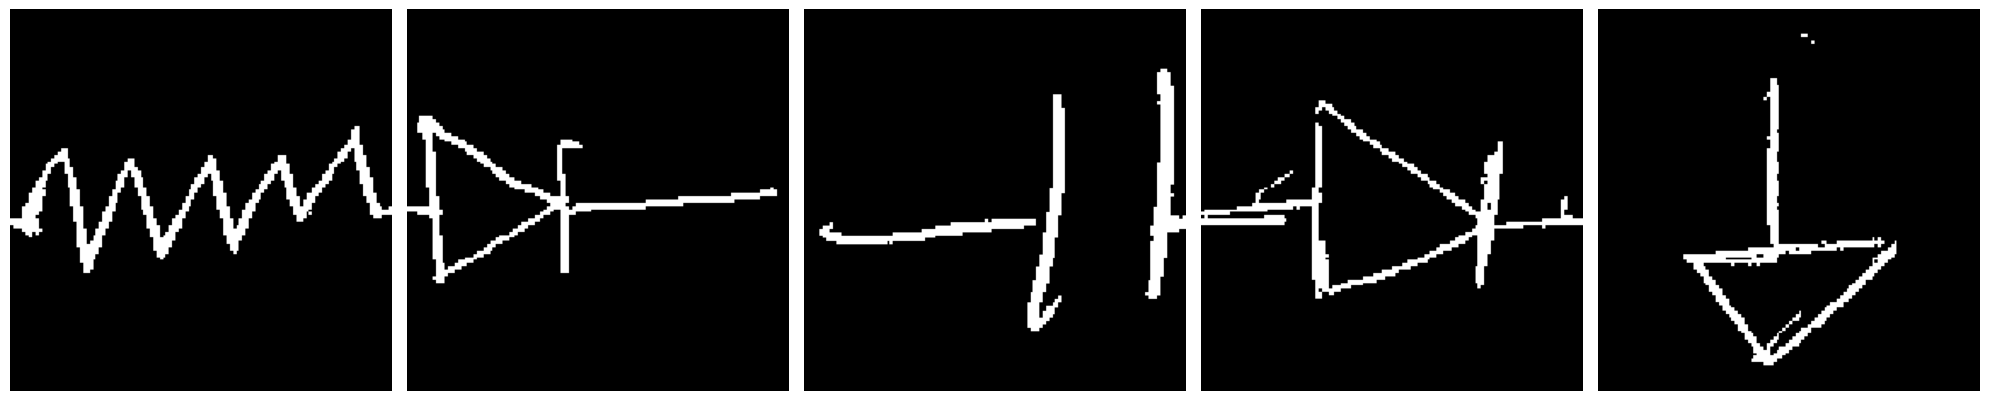

In [ ]:
# implementing the above function to view generated images
sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

## Model - Training and Validation

In [ ]:
model = tf.keras.Sequential([
    # layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(5, activation='softmax')
])
# PRODUCED 70,56% ACCURACY

In [ ]:
# model's components (skeleton)
# model.summary()

In [ ]:
# provides the model with desired metrics 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting model to data - provides both the training and validation data sets
history = model.fit(
    train_data_gen,
    steps_per_epoch=540 // batch_size,              # hard divide (division that rounds) - 540 is the total number of training samples (108 x 5)
    epochs=epochs,
    # callbacks=[cp_callback], # commented out
    validation_data=validate_data_gen,
    validation_steps=180 // batch_size,             # hard divide (division that rounds) - 180 is the total number of training samples (36 x 5)
    # class_weight=class_weights # commented out
)

Epoch 1/5
16/16 [==============================] - 75s 5s/step - loss: 1.2169 - accuracy: 0.5256 - val_loss: 1.0294 - val_accuracy: 0.5688
Epoch 2/5
16/16 [==============================] - 75s 5s/step - loss: 0.5525 - accuracy: 0.7520 - val_loss: 0.7402 - val_accuracy: 0.7000
Epoch 3/5
16/16 [==============================] - 77s 5s/step - loss: 0.1308 - accuracy: 0.9646 - val_loss: 1.2646 - val_accuracy: 0.7188
Epoch 4/5
16/16 [==============================] - 78s 5s/step - loss: 0.0455 - accuracy: 0.9882 - val_loss: 1.2475 - val_accuracy: 0.7500
Epoch 5/5
16/16 [==============================] - 76s 5s/step - loss: 0.0137 - accuracy: 0.9980 - val_loss: 1.3796 - val_accuracy: 0.7688


In [ ]:
# obtaining the accuracy and loss data such that it can be plotted below
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

Text(0.5, 1.0, 'Training and Validation Accuracy')

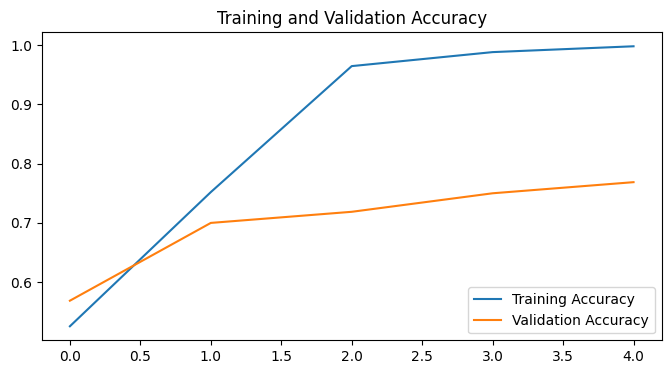

In [ ]:
# plot of the training and validation data set's accuracy
plt.figure(figsize=(8, 4))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

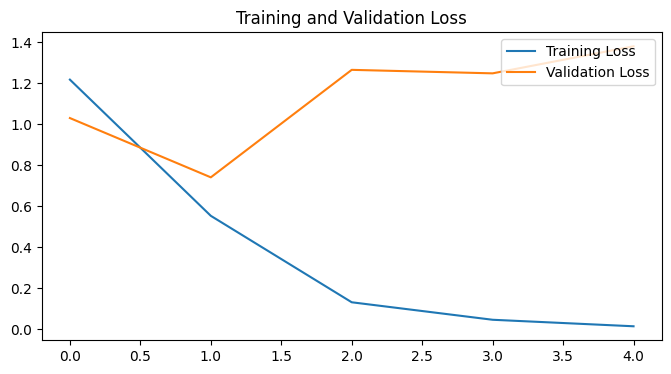

In [ ]:
# plot of the training and validation data set's loss
plt.figure(figsize=(8, 4))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model - Testing

In [ ]:
# sending in the testing data set
scores = model.evaluate(test_data_gen)

6/6 [==============================] - 6s 947ms/step - loss: 0.5268 - accuracy: 0.8722


In [ ]:
# obtaining the overall accuracy and loss when the model is applied to the testing data
print("Test Accuracy: %.2f%%" % (scores[1]*100))
print("Test Loss: %.2f%%" % (scores[0]))

Test Accuracy: 87.22%
Test Loss: 0.53%


## Confusion Matrix

In [ ]:
# ground truths 
y_pred = model.predict(test_data_gen)

6/6 [==============================] - 6s 944ms/step


In [ ]:
# highest prediction score (models prediction)
y_pred_choices = np.argmax(y_pred, axis=1)

In [ ]:
# compares y true and y pred
cm = confusion_matrix(test_data_gen.classes, y_pred_choices)

In [ ]:
# sanity check - ensure that all the classifications are in the same order
class_names_train = list(train_data_gen.class_indices.keys())
class_names_validate = list(train_data_gen.class_indices.keys())
class_names_test = list(train_data_gen.class_indices.keys())
print(f"{class_names_train}\n{class_names_validate}\n{class_names_test}")

['capacitor', 'diode', 'ground', 'inductor', 'resistor']
['capacitor', 'diode', 'ground', 'inductor', 'resistor']
['capacitor', 'diode', 'ground', 'inductor', 'resistor']


In [ ]:
# prints classification report
print(classification_report(test_data_gen.classes, y_pred_choices, target_names=class_names_train))

              precision    recall  f1-score   support

   capacitor       0.94      0.86      0.90        36
       diode       0.95      0.97      0.96        36
      ground       0.97      0.94      0.96        36
    inductor       0.87      0.75      0.81        36
    resistor       0.68      0.83      0.75        36

    accuracy                           0.87       180
   macro avg       0.88      0.87      0.87       180
weighted avg       0.88      0.87      0.87       180



In [ ]:
# function that plots a confusion matrix based on the model's testing
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues): 
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize by row sums
        cm *= 100
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


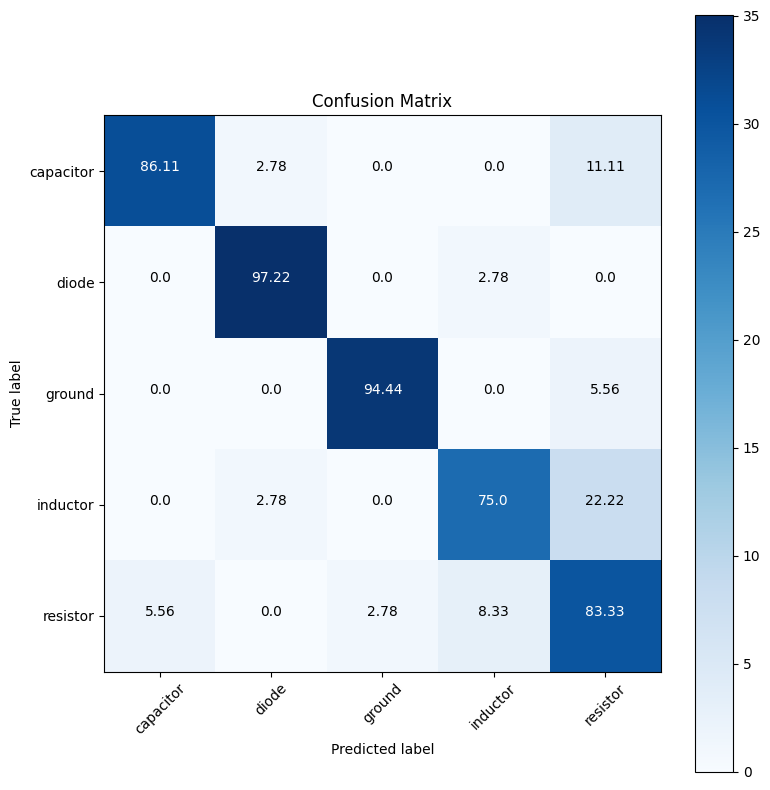

In [ ]:
# plot of confusion matrix - percentages shown
plot_confusion_matrix(cm, class_names_train, title='Confusion Matrix')